# Process of Benchmarking data

In [1]:
from IPython.display import clear_output
# !pip install forest-benchmarking
clear_output()

In [2]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [4]:
target_qubits = [41,42]
# target_qubits = [0]
n_qubits = len(target_qubits)

k_m = 50 #number of sequences
n_m = 800 #number of shots

max_depth = 70
min_depth = 1

epsilon = 0.01
# machine_title = '1q-qvm'
machine_title = 'Aspen-M-3'
# noise_model = 'depolarising_noise'
noisy_machine = machine_title

# noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)

In [5]:
path

'C:\\Users\\mohsen\\Documents\\Python_pros\\git_controlled\\Randomized_Benchmarking_protocol\\output_storage\\Aspen-M-3'

In [6]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [7]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['target qubits'] == str(target_qubits)]
    return dataframe

def filter_large_errors(dataframe):
    return dataframe[dataframe['error of fidelity'] <= 0.1]

def filter_circuit_length(dataframe):
    df = dataframe[dataframe['circuit depth'] <= max_depth]
    df = df[df['circuit depth'] >= min_depth]
    return df

def filter_seqs_shots_num(dataframe, sequences_num, shots_num):
    df = dataframe[dataframe['number of shots'] == shots_num]
    df = df[df['number of sequences'] == sequences_num]
    return df

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

def remove_duplicated_points(dataframe):
    new_df = pd.DataFrame()
    for version in dataframe['protocol name'].unique():
        version_df = dataframe[ dataframe['protocol name'] == version ]
        new_df = new_df.append(version_df[~version_df.duplicated(['circuit depth'], keep='last')] ) 
    return new_df

In [8]:
df = capture_bench_dataframe(path)

In [9]:
df = filter_circuit_length(df)
df = filter_large_errors(df)
df = filter_seqs_shots_num(df, sequences_num=k_m, shots_num=n_m)

In [10]:
df = remove_duplicated_points(df)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16648\960225738.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(version_df[~version_df.duplicated(['circuit depth'], keep='last')] )


In [11]:
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = []
    err_fdlty_dict[version] = []
    ordered_layers_dict[version] = []

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version] = avg_fdlty_arr
        err_fdlty_dict[version] = err_fdlty_arr
        ordered_layers_dict[version] = ordered_layers
    except:
        pass

In [12]:
df

,date,target qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
66,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,8,0.435300,0.058889
67,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,9,0.401375,0.047351
68,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,10,0.399350,0.055556
69,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,1,0.755500,0.064066
70,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,2,0.725950,0.066556
71,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,3,0.683225,0.047692
72,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,4,0.623550,0.045418
73,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,5,0.569725,0.050698
74,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,6,0.525550,0.049168
75,2023-04-25,"[41, 42]",50,800,native_conditional_conditional_two_qubits,7,0.476400,0.056439


In [13]:
bench_versions

array(['native_conditional_conditional_two_qubits'], dtype=object)

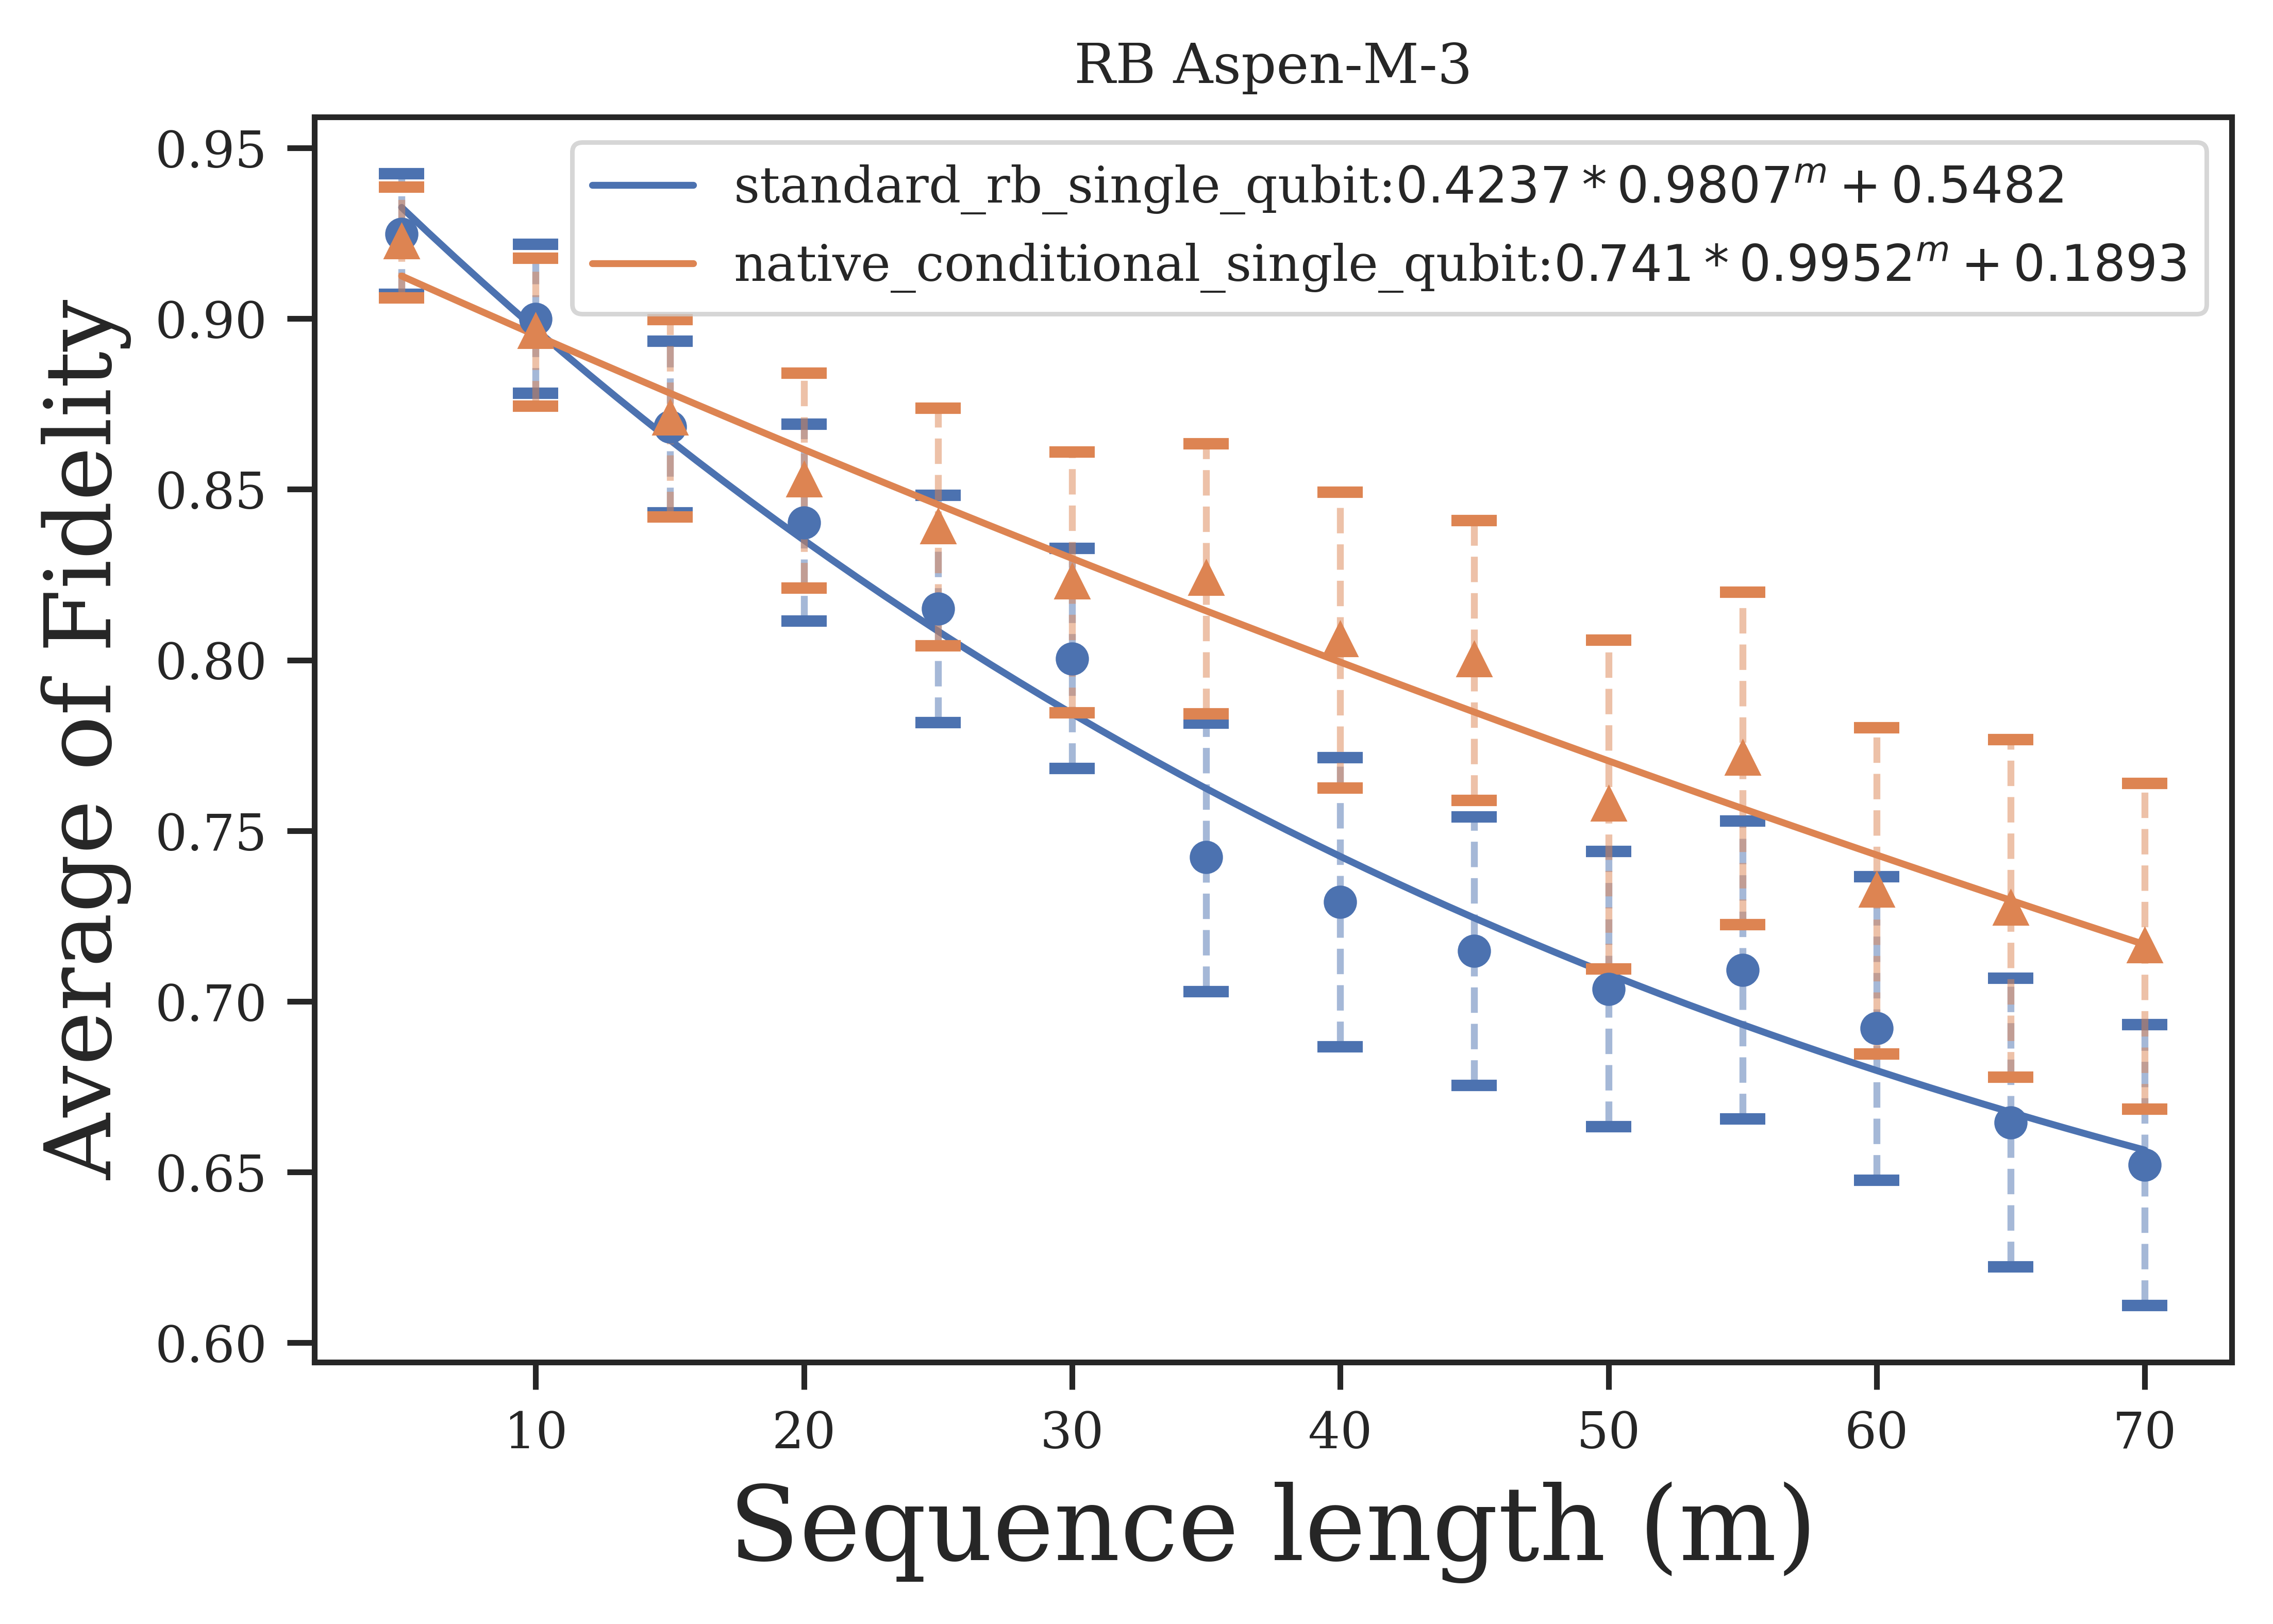

In [14]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

fmt_list = ['o','^']
# for version in ['native_conditional_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for version in ['standard_rb_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for version in ['standard_rb_single_qubit', 'native_conditional_single_qubit', 'standard_rb_non_uniform_single_qubit']:
for i,version in enumerate(['standard_rb_single_qubit', 'native_conditional_single_qubit']):
# for version in ['native_conditional_conditional_two_qubits']:
# for version in ['native_conditional_single_qubit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][:], avg_fdlty_dict[version][:],
               err_fdlty_dict[version][:], fmt = fmt_list[i], label = version, axes = ax)

# plt.loglog()
ax.set_xlabel('Circuit depth (m)', fontsize=18)
ax.set_ylabel('Fidelity average', fontsize=16)
ax.set_title(r'RB {}'.format(noisy_machine))

plt.legend()

# plt.loglog()
fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)))


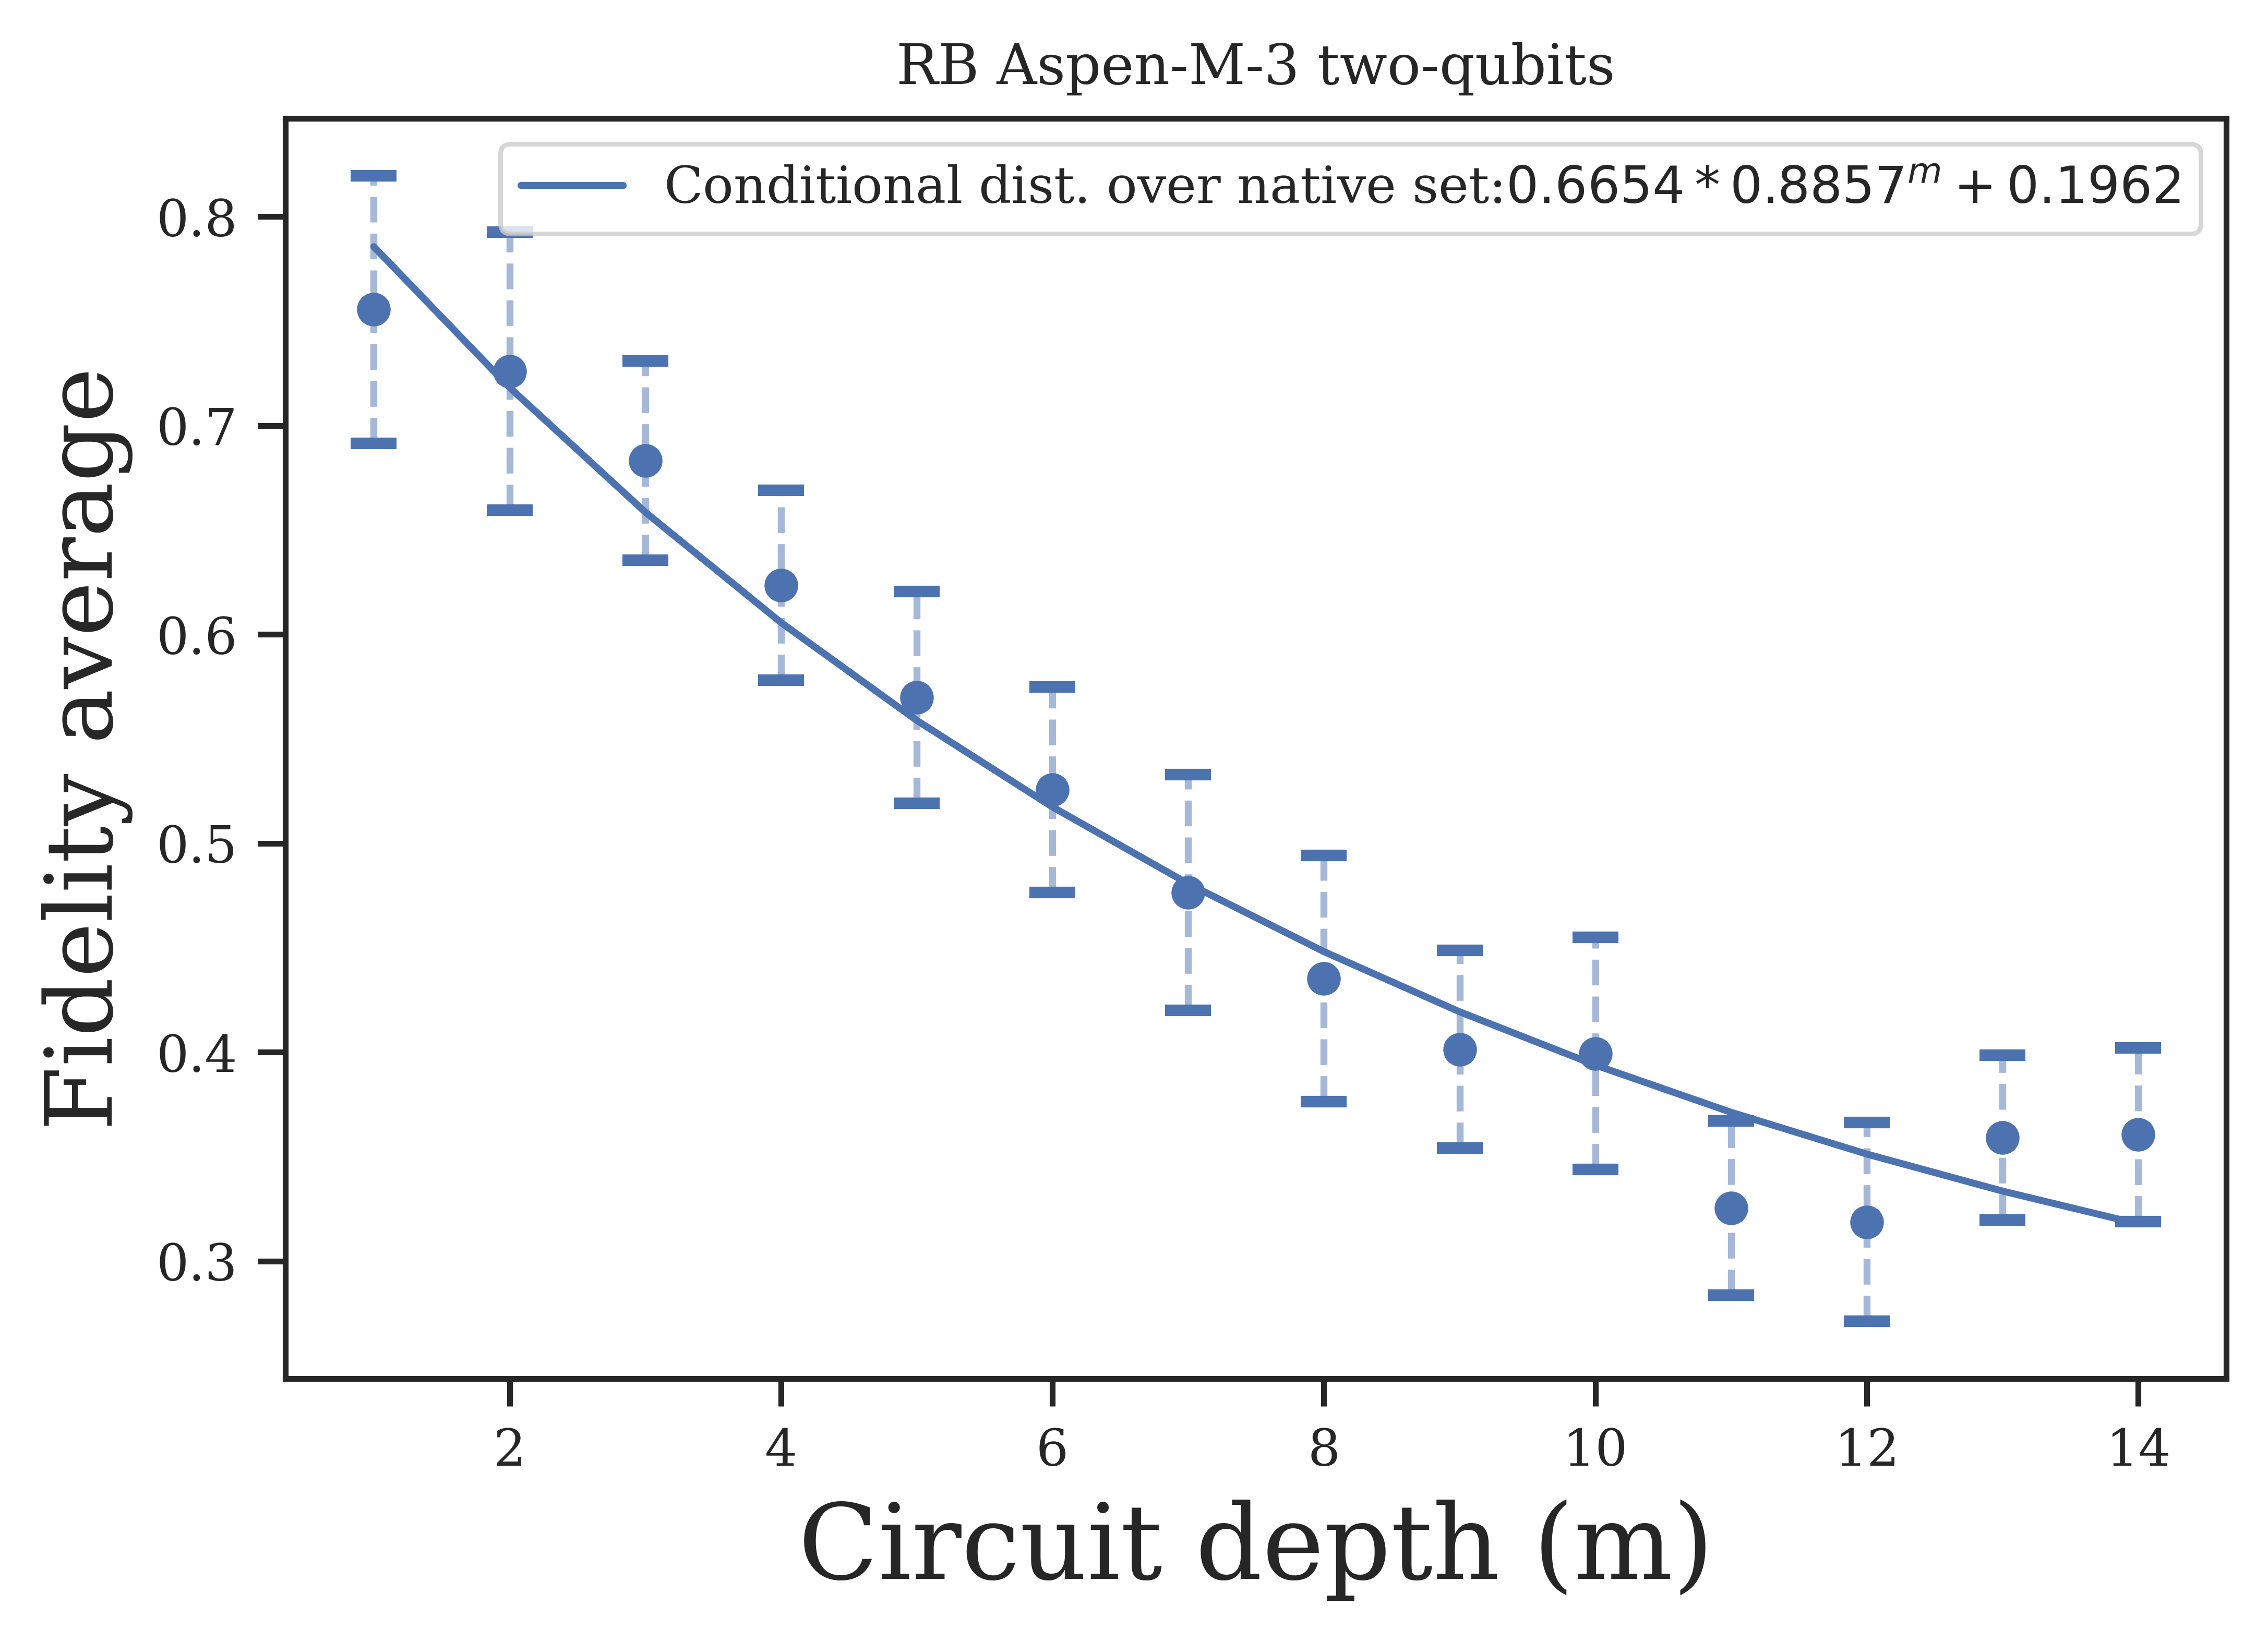

In [14]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

fmt_list = ['o','^']
labels_dict = {'standard_rb_single_qubit':'Compiler two-design',
               'native_conditional_single_qubit':'Conditional dist. over native set',
              'native_conditional_conditional_two_qubits':'Conditional dist. over native set'}
# for version in ['native_conditional_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for version in ['standard_rb_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for version in ['standard_rb_single_qubit', 'native_conditional_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for i,version in enumerate(['standard_rb_single_qubit', 'native_conditional_single_qubit']):
for i,version in enumerate(['native_conditional_conditional_two_qubits']):
# for version in ['native_conditional_single_qubit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][:], avg_fdlty_dict[version][:],
               err_fdlty_dict[version][:], fmt = fmt_list[i], label = labels_dict[version], axes = ax)

# plt.loglog()
ax.set_xlabel('Circuit depth (m)', fontsize=18)
ax.set_ylabel('Fidelity average', fontsize=16)
# ax.set_title(r'RB {} single-qubit'.format(noisy_machine))
ax.set_title(r'RB {} two-qubits'.format(noisy_machine))

plt.legend()

# plt.loglog()
fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)))
